<a href="https://colab.research.google.com/github/hseyeon1006/ESAA_OB/blob/%ED%95%84%EC%82%AC/CH03_HW0904.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

127-154P

#Chapter3. 분류

##3.1 MNIST

* 사용 데이터셋 : MNIST - 고등학생과 미국 인구조사국 직원들이 손으로 쓴 70000개의 작은 숫자 이미지를 모은 데이터

In [2]:
#warning 무시 코드 & 패키지 로드
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

In [9]:
# MNIST 데이터셋 내려받는 코드
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

사이킷런에서 읽어들인 데이터셋들은 일반적으로 비슷한 딕셔너리 구조를 가짐
* 데이터셋을 설명하는 DESCR 키
* 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data 키
* 레이블 배열을 담은 target 키

In [10]:
X,y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


개개의 특성은 0(흰색)부터 255(검은색)까지의 픽셀 강도를 나타냄

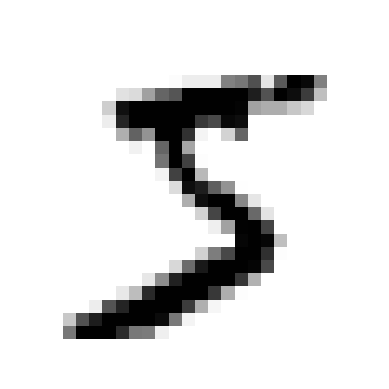

In [11]:
#이미지 하나 확인해보기
import matplotlib as mpl
import matplotlib.pyplot as plt

#샘플의 특성 벡터를 추출하여 25*25 배열로 크기 바꾸기
some_digit = X[0]
some_digit_image=np.array(some_digit).reshape(28,28)

#맷플롯립의 imshow() 함수 사용해 그리기
plt.imshow(some_digit_image, cmap = "binary")
plt.axis("off")
plt.show()

In [12]:
#실제 레이블 확인
y[0]

'5'

In [13]:
#y를 정수로 변환
y = y.astype(np.uint8)

In [14]:
#훈련 세트 60000, 테스트 세트 10000개로 나누기
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

##3.2. 이진 분류기 훈련

ex) 하나의 숫자, 예를 들어 5만 식별

해당 '5-감지기'는 '5'와 '5 아님' 두개의 클래스를 구분할 수 있는 이진 분류기의 한 예임

In [15]:
#분류 작업을 위해 타깃 벡터 만들기
y_train_5 = (y_train == 5)  # 5는 True, 다른 숫자는 False
y_test_5 = (y_test == 5)

분류 모델 선택해서 훈련

여기서 SGDClassifier 클래스를 사용해 확률적 경사 하강법 분류기로 시작 - 해당 분류기는 매우 큰 데이터셋을 효율적으로 처리하는 장점을 지님

In [16]:
#SGDClassifier 모델을 만들고 전체 훈련 세트를 사용해 훈련하기
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(max_iter=5, random_state=42)

SGDClassfier는 훈련하는 데 무작위성을 사용함 -> 결과를 재현하고 싶다면 random_state 매개변수를 지정해야함

In [17]:
#모델을 사용해 숫자5의 이미를 감지하기
sgd_clf.predict([some_digit])

array([ True])

분류기는 이 이미지가 5를 나타낸다고 추측함 (True)

##3.3. 성능 측정

###3.3.1. 교차 검증을 사용한 정확도 측정

In [18]:
#교차검증 구현
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# skfolds = StratifiedKFold(n_splits=3, random_state=42)
skfolds = StratifiedKFold(n_splits=3, random_state=None)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)  # sgd_clf 복제
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9633
0.95695
0.9146


StratifiedKFold : 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링을 수행함. 매 반복에서 분류기 객체를 복제하여 훈련 폴드로 훈련시키고 테스트 폴드로 예측을 만듦. 그런 다음 올바른 예측의 수를 세어 정확한 예측의 비율을 출력함

In [20]:
#cross_val_score() 함수로 교차검증해 모델 평가
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9633 , 0.95695, 0.9146 ])

모든 교차 검증 폴드에 대해 정확도가 90% 이상임

In [21]:
#모든 이미지를 5아님 클래스로 분류하는 더미 분류기 만들어 비교
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [22]:
#정확도 추측
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

정확도가 90% 이상으로 나옴

이 예제는 정확도를 분류기의 성능 측정 지표로 선호하지 읺는 이유를 보여줌. 특히 불균형한 데이터셋을 다룰 때 더욱 그럼

###3.3.2. 오차 행렬

In [23]:
#예측값 만들기
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

array([ True, False, False, ...,  True, False,  True])

cross_val_predict() 함수 : k-겹 교차 검증을 수행하지만 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환함. 즉, 훈련 세트의 모든 샘플에 대해 깨끗한 예측을 얻게됨

In [24]:
#오차 행렬 만들기
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[52336,  2243],
       [ 1060,  4361]])

행 : 실제 클래스

열 : 예측한 클래스

In [25]:
y_train_perfect_predictions = y_train_5   # 완벽한 분류기일 경우
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

[정밀도]
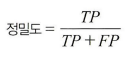

TP : 진짜 양성의 수, FP : 거짓 양성의 수

[재현율]

확실한 양성 샘플 하나만 예측하면 간단히 완벽한 정밀도를 얻을 수 있지만 이는 분류기가 다른 모든 양성 샘플을 무시하기 때문에 유용하지 않음 -> 정밀도는 재현율과 함께 사용

재현율 : 분류기가 정확하게 감지한 양성 샘플의 비율로 민감도 또는 진짜 양성비율이라고도 함

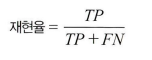

FN : 거짓 음성의 수

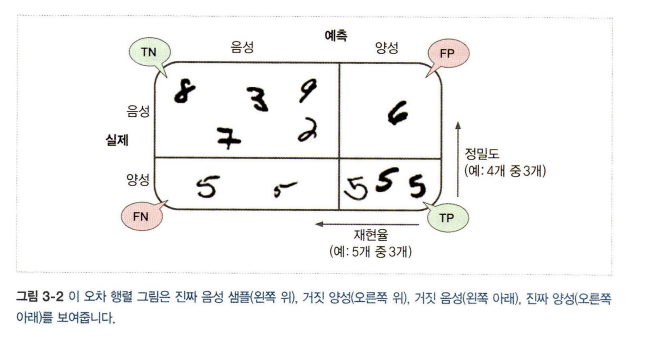

###3.3.3. 정밀도와 재현율

In [26]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.6603573591762568

In [27]:
recall_score(y_train_5, y_train_pred)

0.8044641210108836

[F1-점수]

정밀도와 재현율을 하나의 숫자로 만든 것

두 분류기를 비교할 때 편리함

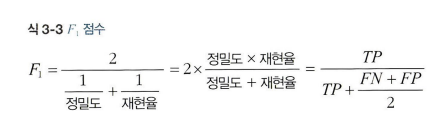

In [28]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7253222453222454

정밀도와 재현율이 비슷한 분류기에서는 F1 점수가 높음

이것이 항상 바람직한 것은 아님

정밀도를 올리면 재현율이 줄고, 그 반대도 마찬가지임 - 정밀도/재현율 트레이드오프 라고 함

###3.3.4. 정밀도/재현율 트레이드 오프

SGDClassifier가 분류를 어떻게 결정하는지 살펴보며 트레이드오프 이해

* 결정 함수를 사용하여 각 샘플의 점수를 계산함. 점수가 임계값보다 크면 샘플을 양성 클래스에 할당하고 그렇지 않으면 음성 클래스에 할당함

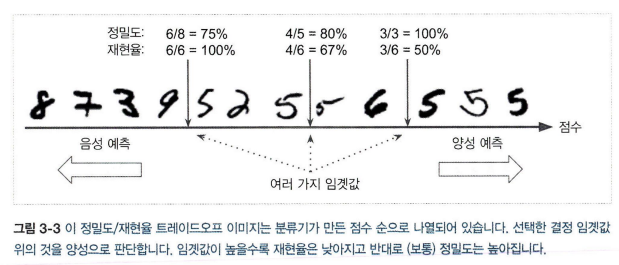

In [29]:
#원하는 임곗값(0)을 정해 예측 만들기
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[57392.7316778]
[ True]


In [31]:
#임곗값 높여보기
threshold = 80000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [32]:
#결정 점수를 반환받도록 지정
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [33]:
#모든 임계값에 대해 정밀도, 재현율 계산 가능함
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

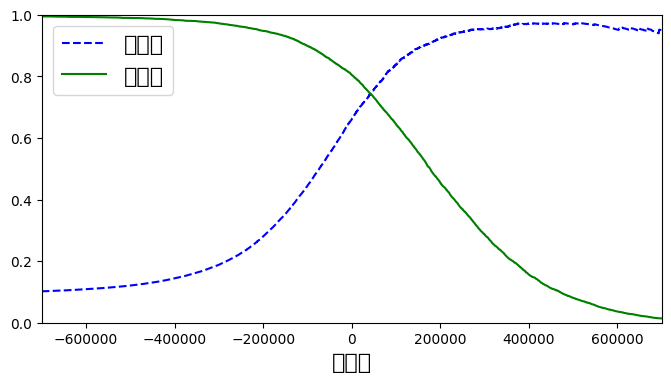

In [34]:
#맷플롯립을 이용해 임계값의 함수로 정밀도, 재현율 그리기
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="정밀도")
    plt.plot(thresholds, recalls[:-1], "g-", label="재현율")
    plt.xlabel("임계값", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

좋은 정밀도/재현율 트레이드오프를 선택하는 다른 방법은 다음과 같은 재현율에 대한 정밀도 곡선을 그리는 것

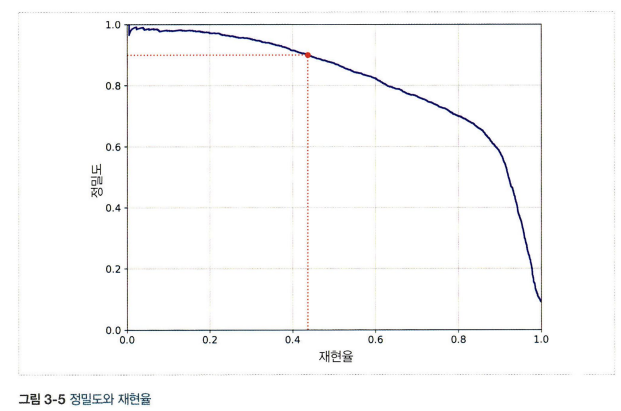

In [35]:
#정확하게 최소한 90%가 정밀도가 되는 가장 낮은 임계값 찾기
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [36]:
#예측 만들기
y_train_pred_90 = (y_scores > threshold_90_precision)

In [37]:
#정밀도와 재현율 확인
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9002203336480957
0.5275779376498801


정밀도 90%를 달성한 분류기를 만들었음

재현율이 너무 낮다면 높은 정밀도의 분류기는 유용하지 않음

###3.3.5. ROC 곡선

정밀도에 대한 재현율 곡선이 아니고 거짓 양성 비율에 대한 진짜 양성 비율의 곡선임

민감도에 대한 1-특이도 그래프임

FPR : 거짓 양성 비율

TPR : 진짜 양성 비율(재현율)

FPR : 양성으로 잘못 분류된 음성 샘플의 비율

TNR : 진짜 음성 비율. 음성으로 정확하게 분류한 음성 샘플의 비율. 특이도라고도 함

In [38]:
#여러 임곗값에서 TPR과 FPR을 계산해야함
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

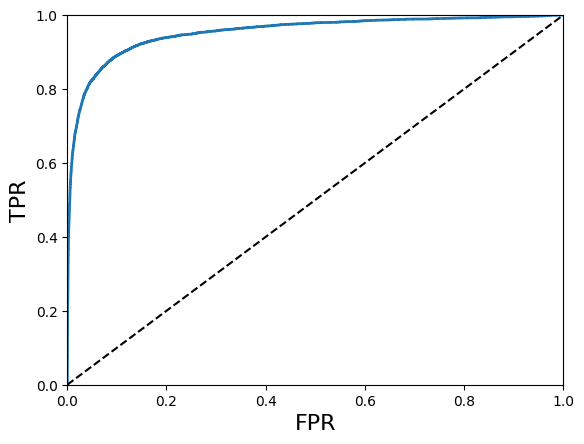

In [39]:
#맷플롯립 이용해서 TPR에 대한 FPR 곡선 나타내기
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('FPR', fontsize=16)
    plt.ylabel('TPR', fontsize=16)

plot_roc_curve(fpr, tpr)
plt.show()

여기서도 트레이드오프가 있음.

TPR이 높을수록 분류기가 만드는 거짓 양성(FPR)이 늘어남

점선 : 완전한 랜덤 분류기의 ROC 곡선을 의미함

좋은 분류기는 이 점선에서 최대한 멀리 떨어져야 함

곡선 아래의 면적(AUC)를 측정하면 분류기를 비교할 수 있음

In [40]:
#AUC 계산하는 함수 이용
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9536789698168869

In [41]:
#RandomForestClassifier를 훈련시켜 SGDClassifier의 ROC곡선과 ROC AUC 점수 비교
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [42]:
# 양성 클래스 확률을 점수로 사용하기
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

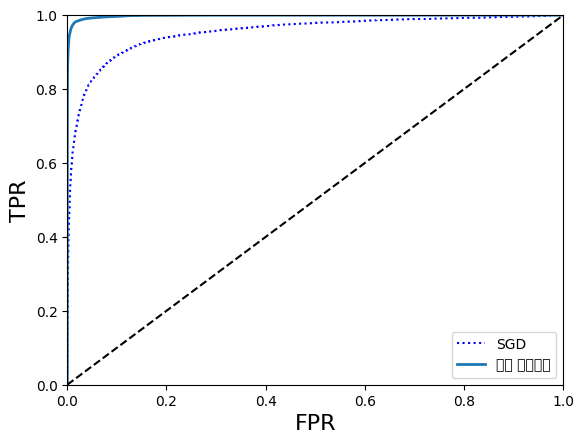

In [43]:
#두가지 ROC 곡선 함께 그리기
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "랜덤 포레스트")
plt.legend(loc="lower right")
plt.show()

RF의 ROC 곡선이 왼쪽 위 모서리에 더 가까워 SGD보다 훨씬 좋아보임

In [44]:
#ROC AUC 점수 계
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

###3.4. 다중 분류

다중 분류기 : 둘 이상의 클래스를 구별할 수 있음

* OvR(OvA) 전략 : 이미지를 분류할 때 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택
 * OvO 전략 : 0과 1 구별, 0과 2 구별, 1과 2 구별과 같이 각 숫자의 조합마다 이진 분류기를 훈련시키는 것임. 장점은 각 분류기의 훈련에 전체 훈련 세트 중 구별할 두 클래스에 해당하는 샘플만 필요하다는 것임

In [45]:
#서포트 벡터 머신 분류기를 테스트
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train,y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [47]:
#decision_function()은 샘플 당 10개의 점수를 반환
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([57392.7316778])

가장 높은 점수가 클래스 5에 해당하는 값

In [48]:
print(np.argmax(some_digit_scores))
print(svm_clf.classes_)
print(svm_clf.classes_[5])

0
[0 1 2 3 4 5 6 7 8 9]
5


In [49]:
#SVC 기반으로 OvR 전략 사용하는 다중 분류기 만들기
from sklearn.multiclass import OneVsOneClassifier

ovr_clf = OneVsOneClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [50]:
len(ovr_clf.estimators_)

45

In [51]:
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [52]:
# decision_function() : 클래스마다 하나의 값 반환
# SGD 분류기가 클래스마다 부여한 점수 확인
sgd_clf.decision_function([some_digit])

array([[-473897.80801197, -644255.86485802, -347352.99430408,
         -30942.4528106 , -560971.15600433,  -42695.14872161,
        -495355.44702264, -327659.64997194, -485909.1798798 ,
        -495629.95766748]])

분류기가 예측 결과에 강한 확신을 보이고 있음을 알 수 있음. 대부분의 점수가 큰 음수이지만 클래스 5의 점수는 매우 큼

In [53]:
#cross_val_score() 이용해서 SGDClassifier 정확도 평가하기
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.8684 , 0.85975, 0.85475])

In [54]:
#데이터 스케일 조정하기
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.906  , 0.9074 , 0.91205])

###3.5. 에러 분석

In [55]:
#cross_val_predict()로 예측 만들고 오차행렬 함수 호출하기
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5734,    2,   26,    9,   11,   45,   42,    9,   41,    4],
       [   1, 6482,   42,   31,    7,   40,    6,    9,  112,   12],
       [  58,   41, 5293,  106,   90,   31,   93,   60,  169,   17],
       [  49,   40,  143, 5322,    4,  236,   37,   57,  150,   93],
       [  25,   25,   33,    9, 5359,    8,   54,   29,   95,  205],
       [  77,   44,   38,  180,   81, 4603,   99,   23,  183,   93],
       [  36,   31,   42,    2,   41,  102, 5617,    3,   44,    0],
       [  31,   26,   73,   34,   57,   14,    3, 5750,   19,  258],
       [  48,  164,   69,  139,   12,  160,   49,   21, 5054,  135],
       [  44,   35,   23,   89,  153,   39,    2,  186,   83, 5295]])

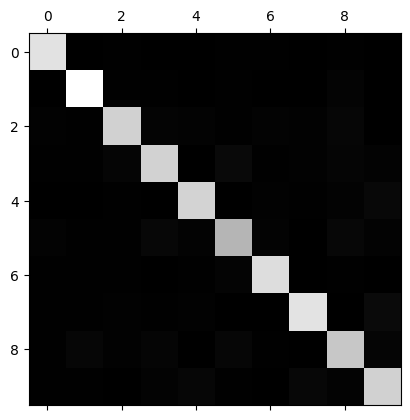

In [56]:
#matshow() 이용해서 이미지로 표현하기 -> 보기에 편리함
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

대부분의 이미지가 올바르게 분류되었음을 나타내는 주대각선에 있으므로 매우 좋아보임.

숫자 5가 다른 숫자보다 어두워보임 -> 숫자 5의 이미지가 적거나 분류기가 숫자 5를 다른 숫자만큼 잘 분류하지 못한다는 뜻

In [57]:
#에러 비율 비교하기
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

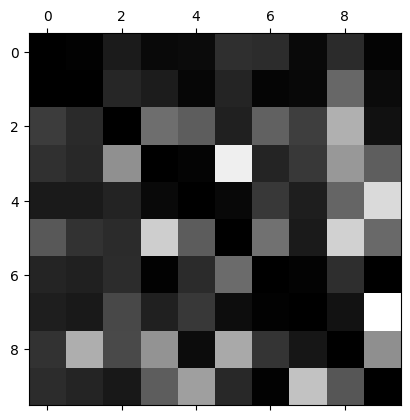

In [58]:
#주대각선을 0으로 채워서 그래프 그리기
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

분류기가 만든 에러 확인 가능함

클래스 8의 열이 상당히 밝음 -> 많은 이미지가 8로 잘못 분류되었음을 암시함. but 클래스 8의 행은 그리 나쁘지 않음 -> 실제 8이 적절히 8로 분류되었음

-> 오차행렬은 반드시 대칭인 것이 아님

In [59]:
#맷플롯립의 imshow() 사용하는 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis("off")

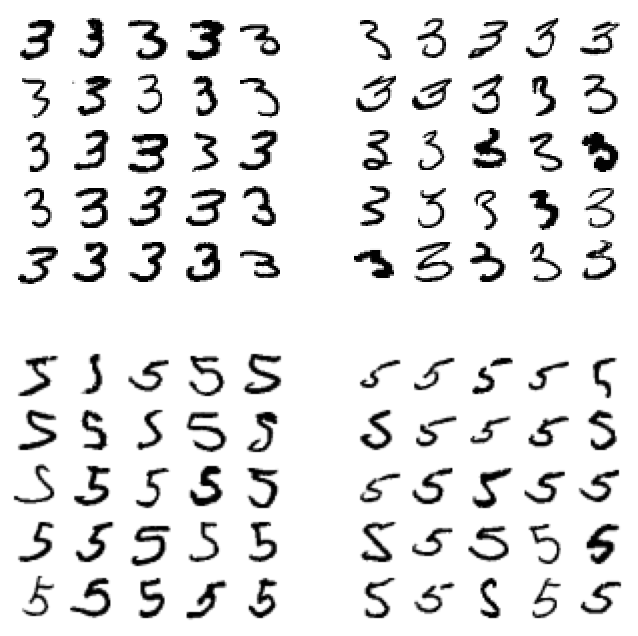

In [60]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

왼쪽의 5*5 블록 두 개는 3으로 분류된 이미지이고 오른쪽 5x5 블록 두 개는 5로 분류된 이미지임.

대부분의 잘못 분류된 이미지는 확실히 에러인 것 같고 분류기가 실수한 이유를 이해하기 어려움 -> 선형모델인 SGDClassifier를 사용했기 때문임

##3.6 다중 레이블 분류

여러 개의 이진 꼬리표를 출력하는 분류 시스템

In [61]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [62]:
#예측 만들기 -> 레이블 두 개 출력
knn_clf.predict([some_digit])

array([[False,  True]])

In [63]:
#다중 레이블 분류기 평가 - F1 score의 평균
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
print(f1_score(y_multilabel, y_train_knn_pred, average="macro"))

0.976410265560605


##3.7 다중 출력 분류

다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것. 즉, 값을 두 개 이상 가질 수 있음

In [64]:
#픽셀 강도에 잡음 추가. 타깃 이미지는 원본 이미지가 됨
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [65]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = plt.cm.binary,
               interpolation="nearest")
    plt.axis("off")

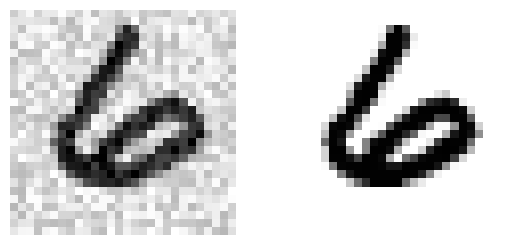

In [66]:
some_index = 5501
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

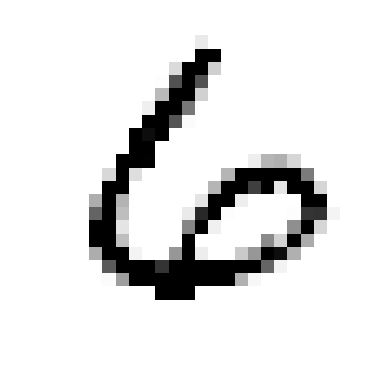

In [67]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)